In [1]:
import pandas as pd
import pickle, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import date
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output

c:\Users\Eugene Chen\.conda\envs\mne\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import dataset

In [2]:
# Load the data from a pickle file
with open('data/test.pickle', 'rb') as f:
    test = pickle.load(f)

# Load the data from a pickle file
with open('data/train.pickle', 'rb') as f:
    train = pickle.load(f)

In [3]:
train = train.dropna()
y_train = train['seizure']
X_train = train.drop(columns = 'seizure')

test = test.dropna()
y_test = test['seizure']
X_test = test.drop(columns = 'seizure')

#### Auxiliar methods

In [41]:
def metrics(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}
    return pd.DataFrame.from_dict(dict)

In [5]:
def accuracy(ys, ts):
    ys = ys > 0.5
    correct_prediction = torch.eq(ys, ts)
    m = torch.mean(correct_prediction.float())
    return m

### K Neighbors

In [151]:
%%time
knn=KNeighborsClassifier(n_neighbors=60, n_jobs=-1)
knn.fit(X_train.values, y_train)
y_pred = knn.predict(X_test.values)

CPU times: total: 219 ms
Wall time: 68 ms


In [152]:
metrics(y_test, y_pred).style.hide(axis="index")

metric,precision
sensitivity,88.337%
specificity,89.056%
accuracy,88.698%


### SVM

In [154]:
%%time
svm=SVC(kernel='linear')
svm.fit(X_train.values, y_train)
y_pred = svm.predict(X_test.values)

CPU times: total: 3.73 s
Wall time: 3.78 s


In [155]:
metrics(y_test, y_pred).style.hide(axis="index")

metric,precision
sensitivity,86.393%
specificity,87.768%
accuracy,87.083%


### Random forest

In [156]:
%%time
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train.values, y_train)
y_pred = rf.predict(X_test.values)

CPU times: total: 3.45 s
Wall time: 3.48 s


In [157]:
metrics(y_test, y_pred).style.hide(axis="index")

metric,precision
sensitivity,87.257%
specificity,91.416%
accuracy,89.343%


### FF Neural Network

#### Dataset to tensors

In [12]:
class SeizureData(torch.utils.data.Dataset):
    def __init__(self, x_val, y_val):

        self.y_data = torch.tensor(y_val.values.astype(np.float32), requires_grad=False)
        self.x_data = torch.tensor(x_val.values.astype(np.float32), requires_grad=True)
        self.n_samples = self.x_data.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


In [13]:
dataset = SeizureData(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=50,
                          shuffle=True,
                          drop_last=True)
dataset = SeizureData(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=50,
                          shuffle=True,
                          drop_last=True)

#### Model

In [14]:
input_size = X_train.shape[1]
output_size = 1

class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFNN, self).__init__()
        # define layers
        self.lin1 = nn.Linear(input_dim, 64)
        self.norm1 = nn.BatchNorm1d(64)
        self.lrelu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)

        self.lin2 = nn.Linear(64, 16)
        self.norm2 = nn.BatchNorm1d(16)
        self.lout = nn.Linear(16, output_dim)

    def forward(self, x):
        y_pred = self.lin1(x)
        y_pred = self.norm1(y_pred)
        y_pred = self.lrelu(y_pred)
        y_pred = self.drop(y_pred)

        y_pred = self.lin2(y_pred)
        y_pred = self.norm2(y_pred)
        y_pred = self.lrelu(y_pred)
        
        y_pred = self.lout(y_pred)
        return y_pred.squeeze()

model = FFNN(input_size, output_size)
print(model)

FFNN(
  (lin1): Linear(in_features=153, out_features=64, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=64, out_features=16, bias=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lout): Linear(in_features=16, out_features=1, bias=True)
)


#### Loss and Optimization

In [15]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Training

In [16]:
%%time
num_epochs = 25
num_total_steps = len(train_loader)

# Initialize lists for training and validation
train_iter, valid_iter = [], []
train_loss, train_accs = [], []
valid_loss, valid_accs = [], []

# Train the model
iter_num = 0
for epoch in range(num_epochs):

    with torch.no_grad():
        val_losses, val_accs, val_lengths = 0, 0, 0
        for valid_input,valid_label in test_loader:
            outputs = model(valid_input)
            predicted = (outputs>0.5).float()
            val_losses += criterion(outputs, valid_label)
            val_accs += ((predicted == valid_label).sum().item())/valid_label.size(0)
            val_lengths += 1
        valid_accs.append(val_accs / val_lengths)
        valid_loss.append(val_losses / val_lengths)
        valid_iter.append(iter_num)

    for i, (input,label) in enumerate(train_loader):
        
        #forward
        output = model(input)
        loss = criterion(output, label)
        #plot
        train_accs.append(float(accuracy(output, label).data.numpy()))
        train_loss.append(float(loss.data.numpy()))
        train_iter.append(iter_num)
        iter_num += 1
        #backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_iter, train_accs, label='train_accs')
    plt.plot(valid_iter, valid_accs, label='valid_accs')
    plt.legend()
    plt.show()
    print(f"Train, it: {epoch} loss: {train_loss[-1]:.2f} accuracy: {train_accs[-1]:.2f}")
    print(f"Valid, it: {epoch} loss: {valid_loss[-1]:.2f} accuracy: {valid_accs[-1]:.2f}")
    clear_output(wait=True)


CPU times: total: 11min 46s
Wall time: 3min 1s


In [17]:
torch.save(model,'Models/model'+str(date.today())+'.pt')

#### Testing

In [18]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for input, labels in test_loader:
        outputs = model(input)
        # max returns (value ,index)
        predicted = (outputs>0.5).float()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network is : {acc} %')

Accuracy of the network is : 84.22222222222223 %


In [19]:
# Test the model
with torch.no_grad():
    all_predicted = torch.tensor([])
    all_label = torch.tensor([])
    for input, labels in test_loader:
        outputs = model(input)
        # max returns (value ,index)
        all_predicted = torch.cat([all_predicted, (outputs>0.5).float()])
        all_label = torch.cat([all_label, labels])
metrics(all_predicted, all_label).style.hide(axis="index")

metric,precision
sensitivity,92.778%
specificity,78.889%
accuracy,84.444%


#### Accuracy based on threshold

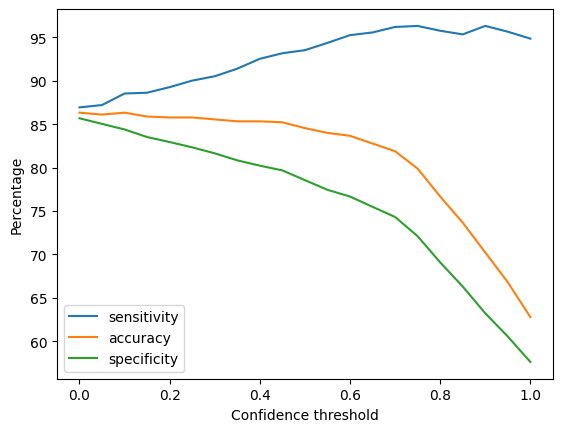

In [20]:
step = 0.05
threshold = np.arange(0, 1+step, step)
values = {}
for i in threshold:
    values[i] = {'snst': [], 'spcf': [], 'accr': []}

with torch.no_grad():
    for input, labels in test_loader:
        outputs = model(input)
        for t in threshold:
            predicted = (outputs>t).float()
            tn, fp, fn, tp = confusion_matrix(predicted, labels, labels=[0, 1] ).ravel()
            if tp+tn == 0:
                values[t]['snst'].append(0)
            else:
                values[t]['snst'].append((tp/(tp+fn))*100)
            if tp+tn == 0:
                values[t]['spcf'].append(0)
            else:
                values[t]['spcf'].append((tn/(fp+tn))*100)
            values[t]['accr'].append(((tp+tn)/(tn+fp+fn+tp))*100)

    sensitivity = []
    specificity = []
    accuracy = []
    for _,v in values.items():
        sensitivity.append(sum(v['snst'])/len(v['snst']))
        specificity.append(sum(v['spcf'])/len(v['spcf']))
        accuracy.append(sum(v['accr'])/len(v['accr']))

plt.plot(threshold, sensitivity, label='sensitivity')
plt.plot(threshold, accuracy, label='accuracy')
plt.plot(threshold, specificity, label='specificity')
plt.ylabel('Percentage')
plt.xlabel('Confidence threshold')
plt.legend()
plt.show()

### Models Comparison

In [67]:
input, output = iter(test_loader).next()

In [162]:
a = [1,2,3,4,5]
a[-1]

5

In [84]:
i = X_test.values[0]
torch.tensor(i.astype(np.float32)).unsqueeze(0).shape

torch.Size([1, 153])

get values model one by one

In [203]:
ffnn_output = [0]
knn_output = [0]
rf_output = [0]
svm_output = [0]
model.eval()
for input, target in zip(X_test.values, y_test.values):
    outputs = model(torch.tensor(input.astype(np.float32)).unsqueeze(0))
    expanded_data = np.expand_dims(input,axis=0)

    ffnn_pred = int((outputs>0).item()) == target
    knn_pred = knn.predict(expanded_data)[0] == target
    rf_pred = rf.predict(expanded_data)[0] == target
    svm_pred = svm.predict(expanded_data)[0] == target

    if not all([ffnn_pred, knn_pred, rf_pred, svm_pred]):
        if ffnn_pred:
            ffnn_output.append(ffnn_output[-1])
        else:
            ffnn_output.append(ffnn_output[-1]+1)
        if knn_pred:
            knn_output.append(knn_output[-1])
        else:
            knn_output.append(knn_output[-1]+1)
        if rf_pred:
            rf_output.append(rf_output[-1])
        else:
            rf_output.append(rf_output[-1]+1)
        if svm_pred:
            svm_output.append(svm_output[-1])
        else:
            svm_output.append(svm_output[-1]+1)

index = list(range(1,len(knn_output)+1))
plt.plot(index, ffnn_output, label='ffnn_output')
plt.plot(index, knn_output, label='knn_output')
plt.plot(index, rf_output, label='rf_output')
plt.plot(index, svm_output, label='svm_output')
plt.xlabel('Number of missed targets')
plt.ylabel('Number of errors')
plt.legend()
plt.show()

In [111]:
X_test.to_numpy().shape

(929, 153)